# Exercise 3

In [19]:
import torch
import torch.cuda
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {'cuda' if torch.cuda.is_available() else 'cpu'}")

Using cpu


In [7]:
def trainNetwork(network, optimizer, lossFunction, trainLoader, validLoader, epochs, device):
    network.train()
    for epoch in range(epochs):
        
        ### TRAINING ###
        trainLoss = 0
        correctTrain = 0
        totalTrain = 0
        for batch_nr, (images, labels) in enumerate(trainLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.to(device)  

            # Predict
            predictions = network(images)

            # Get loss and backpropogate
            loss = lossFunction(predictions, labels)
            loss.backward() 

            # Optimize parameters (weights and biases) and remove gradients after
            optimizer.step() 
            optimizer.zero_grad()

            # Save loss for whole epoch
            trainLoss += loss.item()
            
            # Calculate training accuracy
            _, predictions = torch.max(predictions, 1) 
            correctTrain += (predictions == labels).sum().item() 
            totalTrain += len(images)

            #print(f'Epoch [{epoch+1}/{epochs}] Batch [{batch_nr}/{len(trainLoader)}]')
        

        trainLoss /= len(trainLoader)
        trainAccuracy = 100 * correctTrain / totalTrain

        ### VALIDATION ###
        validLoss = 0
        correctValid = 0
        totalValid = 0
        for batch_nr, (images, labels) in enumerate(validLoader):
            # Move data to GPU (if exists)
            images, labels = images.to(device), labels.to(device)  

            # Predict
            predictions = network(images)

            # Get loss
            loss = lossFunction(predictions, labels)

            # Save loss for whole epoch
            validLoss += loss.item()

            # Calculate vaildation accuracy
            _, predictions = torch.max(predictions, 1) 
            correctValid += (predictions == labels).sum().item() 
            totalValid += len(images)

            #print(f'Epoch [{epoch+1}/{epochs}] Batch [{batch_nr}/{len(validLoader)}]')

        validLoss /= len(validLoader)
        validAccuracy = 100 * correctValid / totalValid

        # Print reuslt of epoch
        print(f'Epoch [{epoch+1}/{epochs}] \t Training Loss: {trainLoss} \t Validation Loss: {validLoss} \t Traning Acc: {trainAccuracy}% \t Validation Acc: {validAccuracy}%')

In [24]:
def extractFeatures(network, loader):
    network.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data in loader:
            images, labels_ = data
            images.to(device), labels_.to(device)  
            output = network(images)
            features.append(output.cpu().numpy())
            labels.append(labels_.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features, labels

In [8]:
# Load and normalizde the MNIST data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

batchSize = 500
validSplit = 0.2 # use 20% of train set as validation

trainValidSet = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testSet = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

validSize = int(np.ceil(len(trainValidSet)*validSplit))
trainSize = int(np.floor(len(trainValidSet)*(1-validSplit)))

trainSet, validSet = torch.utils.data.random_split(trainValidSet, [trainSize, validSize])

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True)
validLoader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=False)


In [9]:
# Define the network class
class ConvNet(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.fc1 = nn.Linear(16 * 4 * 4, 250)
        self.fc2 = nn.Linear(250, 10)
        self.activation = activation

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
class FeatureExtNet(nn.Module):
    def __init__(self, conv_net):
        super().__init__()
        self.conv1 = conv_net.conv1
        self.pool = conv_net.pool
        self.conv2 = conv_net.conv2
        self.activation = conv_net.activation

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        return x

In [10]:
learningRate = 1e-6
epochs = 1
network = ConvNet(F.leaky_relu).to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=learningRate)
lossFunction = nn.CrossEntropyLoss().to(device)
trainNetwork(network, optimizer, lossFunction, trainLoader, validLoader, epochs, device)

Epoch [1/1] 	 Training Loss: 2.301571786403656 	 Validation Loss: 2.301890323559443 	 Traning Acc: 15.320833333333333% 	 Validation Acc: 15.483333333333333%


In [14]:
featureNet = FeatureExtNet(network)
features, labels = extractFeatures(featureNet, trainLoader)
pca = PCA(n_components=2)
pcaFeatures = pca.fit_transform(features)
tSne = TSNE(n_components=2)
tSneFeatures = tSne.fit_transform(features)

In [ ]:

# colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'pink', 'brown', 'orange']
# numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# for color, i in zip(colors, numbers):
#     plt.scatter(
#         X_r[labels == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=2, label=i
#     )
# plt.legend(loc="best", shadow=False, scatterpoints=1)
# plt.title("PCA of IRIS dataset")

In [27]:
def plot(features, labels):
    colorList = ['red', 'blue', 'green', 'purple', 'orange', 'gray', 'pink', 'brown', 'black', 'cyan']
    colors = [colorList[label] for label in labels]

    plt.scatter(features[:,0], features[:,1], c=colors)
    plt.show()

In [28]:
plot(pcaFeatures, labels)
plot(tSneFeatures, labels)

TypeError: only integer scalar arrays can be converted to a scalar index

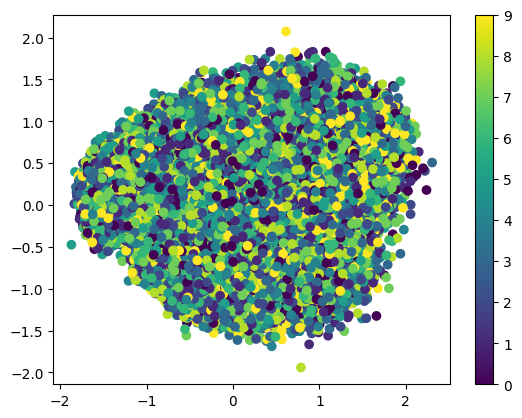

In [25]:
# plt.scatter(pcaFeatures[:,0], pcaFeatures[:,1], c=labels)
# plt.colorbar()
# plt.show()

In [ ]:
learningRate = 1e-3
epochs = 20
network = ConvNet(F.leaky_relu).to(device)

optimizer = torch.optim.SGD(network.parameters(), lr=learningRate)
lossFunction = nn.CrossEntropyLoss().to(device)
trainNetwork(network, optimizer, lossFunction, trainLoader, validLoader, epochs, device)

In [ ]:
featureNet = FeatureExtNet(network)
features, labels = extractFeatures(featureNet, trainLoader)
pca = PCA(n_components=2)
pcaFeatures = pca.fit_transform(features)
tSne = TSNE(n_components=2)
tSneFeatures = tSne.fit_transform(features)

In [ ]:
plot(pcaFeatures, labels)
plot(tSneFeatures, labels)